In [1]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
import cv2  # for image processing
from sklearn.model_selection import train_test_split
import scipy.io
import os
import h5py
from arts_preprocess_utils import load_dataset
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


1.2.1
2.0.6


In [2]:
# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    s = K.get_session()
    return s

In [3]:
# remember to clear session if you start building graph from scratch!
s = reset_tf_session()
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)

## Prepare for training

In [4]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig = load_dataset('/root/work/datasets/wikiart_mini_ic.h5')

In [5]:
train_set_x_orig.shape

(5295, 256, 256, 3)

In [6]:
test_set_x_orig.shape

(1324, 256, 256, 3)

In [7]:
img_Height = train_set_x_orig.shape[1]
img_Width = train_set_x_orig.shape[2]
N_CLASSES= len(np.unique(test_set_y_orig))-1

**Plot painting example**

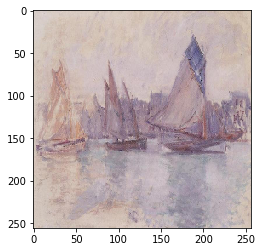

In [8]:
plt.imshow(np.clip(train_set_x_orig[7], 0, 255).astype('uint8')[...,::-1])

In [9]:
train_set_y_orig[7]

1.0

In [10]:
X_train = train_set_x_orig
y_train = train_set_y_orig

X_test = test_set_x_orig
y_test = test_set_y_orig

## Split train dev

In [11]:
X_train, X_dev, y_train, y_dev = train_test_split(train_set_x_orig, train_set_y_orig, test_size=0.25)

### Normalize data

In [12]:
batch_size = 32

# this is the augmentation configuration we will use for training:
train_datagen = ImageDataGenerator(rescale=1./255, featurewise_center= True, 
                                   featurewise_std_normalization=True, shear_range=0.2, zoom_range=0.2)
# this is the augmentation configuration we will use for testing:
# only rescaling
dev_datagen = ImageDataGenerator(rescale=1./255)


In [13]:
train_datagen.fit(X_train)
dev_datagen.fit(X_dev)

In [ ]:
y_train = keras.utils.np_utils.to_categorical(num_classes=N_CLASSES, y= train_set_y_orig)
y_test = keras.utils.np_utils.to_categorical(num_classes=N_CLASSES, y= test_set_y_orig)

## Training

**Simple model**

In [ ]:
from models import Simple_Model

simple_model = Simple_Model()
model = simple_model.get_model(input_shape = (img_Height,img_Width,3), n_classes=N_CLASSES)

In [ ]:
model.summary()

**Inception model**

In [14]:
from models import Inception_model

inception_model = Inception_model()
model = inception_model.get_model(input_shape =(img_Height,img_Width,3), n_classes=N_CLASSES, use_imagenet=True)

In [15]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 127, 127, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 127, 127, 32)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 127, 127, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

**ResNet50**

In [ ]:
from models import ResNet_model

resnet_model = ResNet_model()
model = resnet_model.get_model(input_shape =(img_Height,img_Width,3), n_classes=N_CLASSES, use_imagenet=True)

In [ ]:
model.summary()

**set all layers trainable by default and prepare batch norm for fine-tuning**

In [16]:
# set all layers trainable by default and prepare batch norm for fine-tuning
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, keras.layers.BatchNormalization):
        # we do aggressive exponential smoothing of batch norm 
        # parameters to faster adjust to our new dataset
        layer.momentum = 0.8
    
# fix deep layers (fine-tuning only last n)
for layer in model.layers[:-2]:
    layer.trainable = False

**Train model**

In [17]:
# compile new model
model.compile(
    loss='binary_crossentropy',  
    optimizer=keras.optimizers.adamax(lr=1e-2),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  # report accuracy during training
)

In [ ]:
model.fit_generator(
        train_datagen.flow(x=X_train,y=y_train, batch_size=batch_size),
        steps_per_epoch=len(X_train) // batch_size,
        epochs=20,
        validation_data=dev_datagen.flow(x=X_dev, y= y_dev, batch_size=batch_size),
        validation_steps=len(X_dev) // batch_size)
model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/20
124/124 [==============================] - 1342s - loss: 0.2740 - acc: 0.8891 - val_loss: 0.6613 - val_acc: 0.6448
Epoch 2/20
124/124 [==============================] - 1349s - loss: 0.2015 - acc: 0.9246 - val_loss: 1.4237 - val_acc: 0.4512
Epoch 3/20
124/124 [==============================] - 1370s - loss: 0.1738 - acc: 0.9342 - val_loss: 6.2699 - val_acc: 0.5085
Epoch 4/20
124/124 [==============================] - 1385s - loss: 0.1755 - acc: 0.9260 - val_loss: 6.4083 - val_acc: 0.5178
Epoch 5/20
124/124 [==============================] - 1412s - loss: 0.1654 - acc: 0.9335 - val_loss: 5.6063 - val_acc: 0.5712
Epoch 6/20
124/124 [==============================] - 1412s - loss: 0.1466 - acc: 0.9438 - val_loss: 5.5842 - val_acc: 0.5766
Epoch 7/20
124/124 [==============================] - 1481s - loss: 0.1711 - acc: 0.9394 - val_loss: 6.1783 - val_acc: 0.5658
Epoch 8/20
124/124 [==============================] - 1473s - loss: 0.1579 - acc: 0.9399 - val_loss: 7.8601 - val_acc:

In [ ]:
plt.imshow(np.clip(X_dev[18], 0, 255).astype('uint8')[...,::-1])

In [ ]:
X = X_dev[10:20,:,:,:] * (1./255)

In [ ]:
model.predict(X).round()

In [ ]:
y_dev[10:20]

### MAE

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
pred = model.predict(X_dev)

In [ ]:
mean_absolute_error(y_pred=pred, y_true=y_dev)